# bacmeta

In [79]:
import os, sys, glob, csv, gzip, re, pickle, random, string
from tqdm import tqdm as tqdm
from Bio import SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def write_fasta(entries, outpath):
    with open(outpath, "w") as f:
        for entry in entries:
            seqid, sequence = entry            
            fasta_entry = f">{seqid}:contig_0:0:0\n{sequence}\n"
            f.write(fasta_entry)
            
            
def generate_config(
    config_path,
    OPFN,        #graph_name
    GENR,        #Number of generations to run
    SUMI,        #Summary info: Generation interval of computing summaries. (1/10 of GENR)
    SEQI,        #Sequence saving: Generation interval (1/10 of GENR)
    MUTD,        #Do mutation documenting with this interval, give 0 to use recombination documenting interval RECI  (1/10 of GENR)

    LOLE,        #Length of locus
    NLOC,        #Number of loci in bacteria
    NBAC,        #Number of bacteria in population
    NPOP,        #Number of populations in metapopulation
    
    MUTR = 2e-7, #Mutation rate per nucleotide per population per generation
    GWDS = 0.01,  #Loci-wise mismatches and mutation-only loci-wise mismatches: Size as proportion of the population.
    
    INSR = 0,    #Insertion rate in relation to mutations
    DELR = 0,    #Deletion rate in relation to mutations
    INDM = 0.02, #Maximum indel length as a proportion of the loci length

    RECR = 3.21, #Recombination rate in relation to mutations
    RECL = 500,  #Recombination mean length. Give (0) if whole loci are to be recombined
    RECA = 18,   #Recombination acceptance parameter for similarity test
    
    MIGI = 0,    #Using migration rates from "migration.input"-file (1) or universal value given with MIGR (0)
    MIGR = 0.01, #Mean migration rate scaler
    MIGP = 0.01, #Migration probability
    MICA = 0.0,  #Mean microepidemic amount
    MICS = 0.0,  #Mean microepidemic size scaler
    
    SEED = 617,   #Set seed or give zero to have random seed from time. 
    SEQS = 0.01,  #Sequence saving: Sample size as proportion of population
    INDD = 1,     #Do indel documenting (1) or not (0)
):

    run_config = {
        'OPFN': OPFN,
        'GENR': GENR,
        'SUMI': SUMI,
        'SEQI': SEQI,
        'MUTD': MUTD,
        
        'LOLE': LOLE, 
        'NLOC': NLOC,      
        'NBAC': NBAC,        
        'NPOP': NPOP,        

        'MUTR': MUTR,
        'GWDS': GWDS,
        'INSR': INSR,
        'DELR': DELR,
        'INDM': INDM,

        'RECR': RECR,
        'RECL': RECL,
        'RECA': RECA,

        'MIGI': MIGI,
        'MIGR': MIGR,
        'MIGP': MIGP,
        'MICA': MICA,
        'MICS': MICS,

        'SEED': SEED,
        'SEQS': SEQS,
        'INDD': INDD,   
        'ISEQ': 1,
        'SEQS': SEQS,
    }
    with open(config_path, 'w') as f:
        for k, v in run_config.items():
            f.write(f'{k}: {v}\n') 

In [2]:
import random 

def random_seed(length):
    random.seed()
    min = 10**(length-1)
    max = 9*min + (min-1)
    return random.randint(min, max)

In [34]:
GENR = 25000
SUMI = 1000 # int(GENR/40)
SEQI = SUMI
MUTD = SUMI
LOLE = 5000
NLOC = 800
NBAC = 2
NPOP = 25
    
MUTR = 2e-6 # default: 2e-7
GWDS = 0.01 # default: 0.01
INSR = 0.1
DELR = INSR 
INDM = 0.02 # default: 0.02
SEQS = 1

MIGR = 0.01
MIGP = 0.0
MICA = 0.0

RECR = 0
RECL = 0
RECA = 0

for _ in range(10):
    trial_name = str(''.join(random.choices(string.ascii_letters, k=6)))
    mut_type = 'SNV' if INSR == 0 else 'SID'
    graph_name = f'{mut_type}NPOP{NPOP}NBAC{NBAC}'.replace('-0', '').replace('0.', '')
    sim_dir = f'/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_{graph_name}/{trial_name}'
    !mkdir -p {sim_dir}
    config_path = f'{sim_dir}/simu{graph_name}.input'
    OPFN = graph_name

    generate_config(
        config_path = config_path,
        OPFN = OPFN,
        GENR = GENR,
        SUMI = SUMI,
        SEQI = SEQI,
        MUTD = MUTD,
        LOLE = LOLE,
        NLOC = NLOC,
        NBAC = NBAC,
        NPOP = NPOP,

        MUTR = MUTR,
        GWDS = GWDS,
        INSR = INSR,
        DELR = DELR,
        INDM = INDM,

        MIGR = MIGR,
        MIGP = MIGP, 
        MICA = MICA,

        RECR = RECR,

        RECL = RECL,
        RECA = RECA,

        SEQS = SEQS,
        SEED = random_seed(6),
    )
    print(config_path)
# !head -n 20 {config_path}

/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/simuSIDNPOP25NBAC2.input


In [5]:
!ls -lhs /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2

total 36K
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 ECValN
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 EGNPPD
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 fCQYQt
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 jBdylO
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 JZzWNG
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 KrFHgB
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 NKKBqt
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 UBZUik
4.0K drwxr-sr-x 2 pc2976 manipmg 4.0K Mar 10 18:30 ZvJQaO


In [20]:
%%bash
run_name=SIDNPOP25NBAC2
for wdir in /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_${run_name}/*; do
    echo $wdir
    cd $wdir
    rm -rf $wdir/outputs
    bacmeta_bin=/burg/pmg/users/pc2976/pkgs/bacmeta/simu
    cp /burg/pmg/users/pc2976/pkgs/bacmeta/default.params ${wdir}
    ${bacmeta_bin} -p ${run_name} -o ${run_name}
    ls -lhs ${wdir}/outputs/
done

/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq
Using specified 'simuSIDNPOP25NBAC2.input' for parameter input. 


Using output file name modifier: 'SIDNPOP25NBAC2'. 


Reading parameter input and initializing randomness.
Parameter reading completed. 
Parameters initialized.
User input parameters set based on file: 'simuSIDNPOP25NBAC2.input'.
No 'outputs' folder found. Creating one.
'outputs' folder created

Reading and initializing successful:
Simulation run file name modifier: SIDNPOP25NBAC2
Number of generations: 25000
Seed parameter: 621997 

Initializing metapopulation.


Initializing population 0.
Reading parameter input and initializing randomness.
Parameter reading completed. 
Parameters initialized.
User input parameters set based on file: 'simuSIDNPOP25NBAC2.input'.
Initializing population 1.
Reading parameter input and initializing randomness.
Parameter reading completed. 
Parameters initialized.
User input parameters set bas

In [35]:
wdir = '/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2'
exp_dir_template = f'{wdir}/bacmeta_*/*'
exps_included = [
    'SIDNPOP25NBAC2',
]
trials_included = sorted([x.split('/')[-1] for x in glob.glob(f'{wdir}/bacmeta_{exps_included[0]}/*')])
trials_included

['ECValN',
 'EGNPPD',
 'JZzWNG',
 'KrFHgB',
 'NKKBqt',
 'UBZUik',
 'ZvJQaO',
 'fCQYQt',
 'jBdylO',
 'lrWNaq']

In [11]:
# !mkdir -p /pmglocal/pc2976/projects/copan_synteny/genome_simulations/
# !rsync -avq /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations/bacmeta_SIDNPOP25NBAC2 /pmglocal/pc2976/projects/copan_synteny/genome_simulations/


In [83]:
for exp_dir in glob.glob(exp_dir_template):
    # exp_dir = exp_dir.replace('/burg/pmg/users/', '/pmglocal/')
    run_name = exp_dir.split('/')[-2].replace('bacmeta_', '') 
    rep_name = exp_dir.split('/')[-1]
    if run_name not in exps_included: continue
    npop = int(run_name.split('NPOP')[-1].split('NBAC')[0])
    n = 0
    for seq_filepath in glob.glob(f'{exp_dir}/outputs/Sequences*-*'):
        timepoint = seq_filepath.split('/')[-1].split('Sequences')[-1].split(f'-')[0]
        generation = f'gen_{timepoint}'
        seqs_dict = dict()
        # if os.path.exists(seq_filepath): continue
        with open(seq_filepath) as f:
            for line in f:
                line = line.rstrip()
                if 'Gene0' in line:  continue
                population = line.split(';')[0]
                individual = line.split(';')[1]
                population = f'pop_{population}'
                individual = f'rep_{n%npop}'
                seqs = ''.join(line.split(';')[2:-1]).upper().replace('-','').replace('(', '').replace(')', '')
                seqs_dict[f'{population}:{individual}']=[tuple([';'.join([rep_name, generation, population, individual]),
                                       seqs.upper()])]

        fa_inputs_dir = f'{exp_dir}/fastas/Generation_{timepoint}'
        os.makedirs(fa_inputs_dir, exist_ok = True)
        for population, seqs_tuple in seqs_dict.items():
            fasta_file = f'{fa_inputs_dir}/{population}.fasta'
            write_fasta(entries = seqs_tuple, outpath = fasta_file)            

In [26]:
# fastANI
# wdir = '/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2'
n_sub=10
for exp_dir in glob.glob(exp_dir_template):
    # exp_dir = exp_dir.replace('/burg/pmg/users/', '/pmglocal/')
    run_name = exp_dir.split('/')[-2].replace('bacmeta_', '')
    trial_name = exp_dir.split('/')[-1]
    if run_name not in exps_included: continue
    if trial_name not in trials_included: continue
    for fa_inputs_dir in glob.glob(f'{exp_dir}/fastas/Generation_*'):
        timepoint = fa_inputs_dir.split('/')[-1].split('_')[-1]
        fastani_dir = f'{exp_dir}/fastani/Generation_{timepoint}'
        outfile = f'{fastani_dir}/fastani.out'
        if os.path.exists(outfile): continue
        !mkdir -p {fastani_dir}
        lines = glob.glob(f'{fa_inputs_dir}/*.fasta')[:n_sub]
        genome_list_path = f'{fastani_dir}/genome_list'
        with open(genome_list_path, 'w') as f:
            for l in lines:
                f.write(f'{l}\n')

        !/burg/pmg/users/pc2976/anaconda3/envs/copangraph/bin/fastANI --ql {genome_list_path} --rl {genome_list_path} -o {outfile}

>>>>>>>>>>>>>>>>>>
Reference = [/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/fastas/Generation_25000/pop_6:rep_0.fasta, /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/fastas/Generation_25000/pop_3:rep_0.fasta, /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/fastas/Generation_25000/pop_10:rep_0.fasta, /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/fastas/Generation_25000/pop_8:rep_0.fasta, /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/fastas/Generation_25000/pop_5:rep_0.fasta, /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/fastas/Generation_25000/pop_4:rep_0.fasta, /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/fastas/Generation_25000

In [27]:
fastani_dict = dict()
fastani_df = pd.DataFrame()

wdir = '/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/'
# wdir_manitou = '/manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan/'
fastani_path_template = f'{wdir}/bacmeta_*/*/fastani/Generation_*/fastani.out'
for fastani_path in sorted(glob.glob(fastani_path_template)):
    experiment = fastani_path.split('/')[-5].replace('bacmeta_', '')
    if experiment not in exps_included: continue  
    
    trial = fastani_path.split('/')[-4]
    if trial not in trials_included: continue  
    
    timepoint = int(fastani_path.split('/')[-2].replace('Generation_', ''))

    exp_dir = wdir + '/' + fastani_path.split('/')[-5] + '/' + trial
    # exp_dir_manitou = exp_dir.replace(wdir, wdir_manitou)
    # assert os.path.exists(exp_dir_manitou)
    # fastani_dir = f'{exp_dir}/fastani/Generation_{timepoint}'
    # if not os.path.exists(fastani_dir):
        # fastani_dir_manitou = fastani_dir.replace(wdir, wdir_manitou)
        # assert os.path.exists(fastani_dir_manitou)
        # !mkdir -p {fastani_dir}
        # !rsync -avq --ignore-existing {fastani_dir_manitou}/fastani.out {fastani_dir}/
     
      
    df = pd.read_table(fastani_path, header = None)
    fastani_dict[experiment] = fastani_dict.get(experiment, dict())
    fastani_dict[experiment][trial] = fastani_dict[experiment].get(trial, dict())
    df.columns = ['query', 'target', 'fastani', 'query_aligned_fragment_count', 'target_aligned_fragment_count']
    df = df.loc[[x!=y for x,y in zip(df['query'], df['target'])]]
    tp_dict = dict()
    for _, row in df.iterrows():
        query = row['query'].split('/')[-1]
        target = row['target'].split('/')[-1]
        tp_dict[tuple(sorted([query, target]))] = row['fastani']
    fastani_dict[experiment][trial][timepoint] = tp_dict

for experiment, df_dicts in fastani_dict.items():
    for trial, df_dict in df_dicts.items():
        for timepoint, d in df_dict.items():
            df = pd.DataFrame.from_dict(d,orient = 'index')
            df.columns = ['fastani']
            df['experiment'] = experiment
            df['trial'] = trial
            df['timepoint'] = timepoint
            fastani_df = pd.concat([fastani_df, df])

fastani_df['pair'] = ['same_pop' if x[0].split(':')[0] == x[1].split(':')[0] else 'diff_pop' for x in fastani_df.index]
display(fastani_df)

,fastani,experiment,trial,timepoint,pair
"(pop_10:rep_0.fasta, pop_6:rep_0.fasta)",99.4068,SIDNPOP25NBAC2,ECValN,1000,diff_pop
"(pop_4:rep_0.fasta, pop_6:rep_0.fasta)",99.4055,SIDNPOP25NBAC2,ECValN,1000,diff_pop
"(pop_5:rep_0.fasta, pop_6:rep_0.fasta)",99.4050,SIDNPOP25NBAC2,ECValN,1000,diff_pop
"(pop_12:rep_0.fasta, pop_6:rep_0.fasta)",99.4053,SIDNPOP25NBAC2,ECValN,1000,diff_pop
"(pop_2:rep_0.fasta, pop_6:rep_0.fasta)",99.4040,SIDNPOP25NBAC2,ECValN,1000,diff_pop
...,...,...,...,...,...
"(pop_12:rep_0.fasta, pop_14:rep_0.fasta)",95.1847,SIDNPOP25NBAC2,lrWNaq,9000,diff_pop
"(pop_12:rep_0.fasta, pop_20:rep_0.fasta)",95.1812,SIDNPOP25NBAC2,lrWNaq,9000,diff_pop
"(pop_14:rep_0.fasta, pop_2:rep_0.fasta)",95.2165,SIDNPOP25NBAC2,lrWNaq,9000,diff_pop
"(pop_14:rep_0.fasta, pop_20:rep_0.fasta)",95.1909,SIDNPOP25NBAC2,lrWNaq,9000,diff_pop


/manitou/pmg/users/pc2976/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/manitou/pmg/users/pc2976/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/manitou/pmg/users/pc2976/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/manitou/pmg/users/pc2976/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

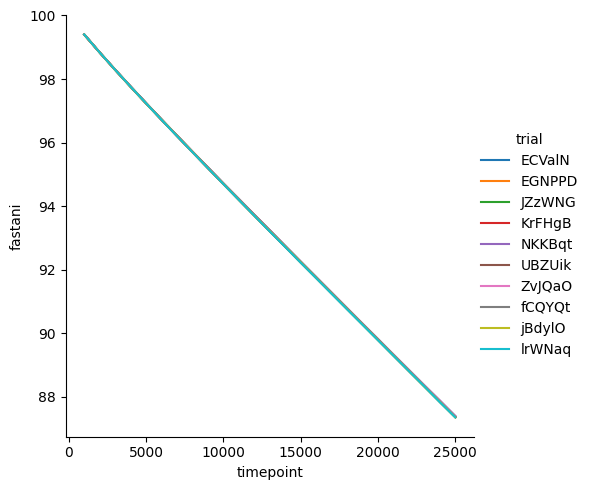

In [28]:
sns.relplot(data = fastani_df, x = 'timepoint', y = 'fastani', hue = 'trial', kind = 'line') #, style = 'pair')
plt.show()

In [75]:
!mkdir -p /manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan_v2
!ls -lhs /manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan_v2
!rsync -avq  --ignore-existing /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2 /manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan_v2/

total 4.0K
4.0K drwxr-sr-x 11 pc2976 manipmg 4.0K Mar 10 18:30 bacmeta_SIDNPOP25NBAC2


# copan

In [85]:
import os, sys, glob, csv, gzip, re, pickle, yaml
sys.path.append('/burg/pmg/users/pc2976/pkgs/copangraph/')
from scripts.build_copangraph_config import *
from tqdm import tqdm as tqdm
from Bio import SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def write_fasta(entries, outpath):
    with open(outpath, "w") as f:
        for entry in entries:
            seqid, sequence = entry            
            fasta_entry = f">{seqid}\n{sequence}\n"
            f.write(fasta_entry)
            
def fasta_to_paired_fastq_gz(fasta_file, output_fastq_r1_gz, output_fastq_r2_gz, read_length=100):
    with open(fasta_file, "r") as fasta, \
         gzip.open(output_fastq_r1_gz, "wt") as fastq_r1, \
         gzip.open(output_fastq_r2_gz, "wt") as fastq_r2:
        
        for record in SeqIO.parse(fasta, "fasta"):
            # Get the sequence from the FASTA record
            seq = str(record.seq)
            
            # Split the sequence into forward and reverse reads
            forward_read = seq[:read_length]
            reverse_read = seq[-read_length:]
            
            # Simulate quality scores
            forward_quality = simulate_quality_scores(len(forward_read))
            reverse_quality = simulate_quality_scores(len(reverse_read))
            
            # Write the forward read to gzipped FASTQ R1
            fastq_r1.write(f"@{record.id}/1\n{forward_read}\n+\n{forward_quality}\n")
            
            # Write the reverse read to gzipped FASTQ R2
            fastq_r2.write(f"@{record.id}/2\n{reverse_read}\n+\n{reverse_quality}\n")

def generate_confifg(
    config_path,
    sample_list,
    graph_name,
    out_dir,
    divergence_threshold = 0.02,
    max_separation = 75,
    num_threads = 8,

    app_name = 'cpg',
    log_file_dir = 'logs', # path relative to the executable
    log_level = 0, # possible values are 1ebug=0(includes Info and Error), Info=1(includes Error), Error=2, None=3
    log_to = 0, # possible values are Console=0, File=1, ConsoleAndFile=2

    window_size = 10,
    kmer_size = 15,
    min_homology_overlap = 1000,
    min_contiguity_overlap = 60,
    max_jump = 200, # largest allowed gap within an alignment
    high_freq_kmer_filter = 1e-16, # remove the top 1-x percentile kmers where x is input
    fasta_file_ext = '.fasta', 
    gfa_file_ext = '.gfa',
    node_color_file_ext = '.ncolor.csv',
    edge_color_file_ext = '.ecolor.csv',
    extended_contigs = 'false',
    sensitive_mode = 'true',
    store_yaml = True,
):
    log_file_dir = config_path.replace(config_path.split('/')[-1], 'log')
    !mkdir -p {log_file_dir}
    run_config = {
        'sample_list': sample_list,
        'graph_name': graph_name,
        'out_dir': out_dir,
        'divergence_threshold': divergence_threshold,
        'num_threads': num_threads,
        'max_separation': max_separation,
        'app_name': app_name,
        'log_file_dir': log_file_dir,
        'log_level': log_level,
        'log_to': log_to,
        'window_size': window_size,
        'kmer_size': kmer_size,
        'min_homology_overlap': min_homology_overlap,
        'min_contiguity_overlap': min_contiguity_overlap,
        'max_jump': max_jump,
        'high_freq_kmer_filter': high_freq_kmer_filter,
        'fasta_file_ext': fasta_file_ext,
        'gfa_file_ext': gfa_file_ext,
        'node_color_file_ext': node_color_file_ext,
        'edge_color_file_ext': edge_color_file_ext,
        'extended_contigs': extended_contigs,
        'sensitive_mode': sensitive_mode,
        'assembler': 'copan',
        'log_file_dir': log_file_dir,
        'log_level': 0,
        'log_to': 1,
        
    }
    with open(config_path, 'w') as f:
        for k, v in run_config.items():
            f.write(f'{k} = {v}\n')            
    if store_yaml:
        config_path_yml = config_path.replace('.ini', '.yaml')
        run_config['metadata'] = f'{sample_dir}/metadata.csv'
        with open(config_path_yml, 'w') as f:
            yaml.dump(run_config, f)
            
def read_gfa(gfa_path):
    with open(gfa_path, 'r') as f:
        data = f.read()
    lines = data.strip().split('\n')

    node_dict = dict()
    edge_dict = dict()
    info_regex = re.compile(r'INFO:\[(.*?)\]:(.*)')
    
    for line in lines:
        parts = line.split('\t')
        entry_type = parts[0]
        if entry_type == 'S':
            node, contig_seq, contig_info = parts[1:]
            contig_info = info_regex.search(contig_info)
            # internal_node = contig_info.group(1)
            # other_ind1 = contig_info.group(2).split(':')[-5]
            # other_ind2 = contig_info.group(2).split(':')[-4]
            # genome_id = contig_info.group(2).split(' ')[0]
            contig_id = contig_info.group(2)
            # contig_id = f'{node}:[{internal_node}]:{other_ind1}:{other_ind2}:{genome_id}'

            seq_start = int(contig_info.group(2).split(':')[-3])
            seq_end = int(contig_info.group(2).split(':')[-2])
            seq_strand = contig_info.group(2).split(':')[-1]
            node_dict[node] = node_dict.get(node, dict())
            assert len(contig_seq) == abs(seq_start - seq_end)
            node_dict[node][f'{node}:{contig_id}'] = {'seq': contig_seq, 
                                          'seq_start': int(seq_start), 'seq_end': int(seq_end), 'seq_strand': seq_strand,
                                          }

        elif entry_type == 'L':
            node_1 = parts[1]
            node_2 = parts[3]
            connectivity = parts[2] + parts[4]
            edge = (node_1, node_2)
            edge_dict[edge] = {'connectivity': connectivity}

    node_df = pd.DataFrame()
    for node, d in node_dict.items():
        df = pd.DataFrame.from_dict(d, orient = 'index')
        df['node'] = node
        df['contig_id'] = df.index.get_level_values(0)
        df = df.reset_index(drop = True)
        node_df = pd.concat([node_df, df])

    edge_df = pd.DataFrame()
    for edge, d in edge_dict.items():
        df = pd.DataFrame.from_dict(d, orient = 'index')
        df['connectivity'] = df.index.get_level_values(0)
        df['node_1'] = edge[0]
        df['node_2'] = edge[1]        
        df = df.reset_index(drop = True)
        edge_df = pd.concat([edge_df, df])    
    return node_df, edge_df

    
copan_bin = '/burg/pmg/users/pc2976/pkgs/copangraph/bin/release/copangraph'

In [39]:
max_separation = 400 #75
max_jump = 1000 #500
min_homology_overlap = 1000 #100
num_threads = 4

div_thres_list = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09 ,0.1]

In [ ]:
# %%bash 
# orig=/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations
# dest=/manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan

# run_name=bacmeta_SIDNPOP100NBAC2
# trial_name=nbSjUw

# mkdir -p ${dest}/${run_name}/${trial_name}/
# rsync -avq --ignore-existing ${orig}/${run_name}/${trial_name}/fastani ${dest}/${run_name}/${trial_name}/
# rsync -avq --ignore-existing ${orig}/${run_name}/${trial_name}/fastas ${dest}/${run_name}/${trial_name}/
# rsync -avq --ignore-existing ${orig}/${run_name}/${trial_name}/outputs ${dest}/${run_name}/${trial_name}/

In [2]:
# %%bash 
# orig=/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations
# dest=/manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan

# run_name=bacmeta_SNVNPOP100NBAC2
# trial_name=oMOCWn

# mkdir -p ${dest}/${run_name}/${trial_name}/
# rsync -avq --ignore-existing ${orig}/${run_name}/${trial_name}/fastani ${dest}/${run_name}/${trial_name}/
# rsync -avq --ignore-existing ${orig}/${run_name}/${trial_name}/fastas ${dest}/${run_name}/${trial_name}/
# rsync -avq --ignore-existing ${orig}/${run_name}/${trial_name}/outputs ${dest}/${run_name}/${trial_name}/

In [69]:
wdir = '/burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2'
exp_dir_template = f'{wdir}/bacmeta_*/*'
exps_included = [
    'SIDNPOP25NBAC2',
]
trials_included = sorted([x.split('/')[-1] for x in glob.glob(f'{wdir}/bacmeta_{exps_included[0]}/*')])
trials_included

['ECValN',
 'EGNPPD',
 'JZzWNG',
 'KrFHgB',
 'NKKBqt',
 'UBZUik',
 'ZvJQaO',
 'fCQYQt',
 'jBdylO',
 'lrWNaq']

In [93]:
for exp_dir in glob.glob(exp_dir_template):
    run_name = exp_dir.split('/')[-2].replace('bacmeta_', '')
    trial_name =  exp_dir.split('/')[-1]
    if run_name not in exps_included: continue
    if trial_name not in trials_included: continue
    for seq_filepath in glob.glob(f'{exp_dir}/outputs/Sequences*-*'):        
        timepoint = seq_filepath.split('/')[-1].split('Sequences')[-1].split(f'-')[0]
        generation = f'gen_{timepoint}'

        fa_inputs_dir = f'{exp_dir}/fastas/Generation_{timepoint}'
        if not os.path.exists(fa_inputs_dir):
            fa_inputs_dir_manitou = fa_inputs_dir.replace(wdir, '/manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan_v2/')
            assert os.path.exists(fa_inputs_dir_manitou)
            !rsync -avq --ignore-existing {fa_inputs_dir_manitou} {exp_dir}/fastas/
        copan_outputs_dir = f'{exp_dir}/copan/Generation_{timepoint}'
        os.makedirs(copan_outputs_dir, exist_ok = True)
        sample_list_path = f'{copan_outputs_dir}/sample_list.txt'
        with open(sample_list_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            # writer.writerow(['SAMPLES'])   
            for sample in sorted(set([x for x in glob.glob(f'{fa_inputs_dir}/*.fasta')])):
                writer.writerow([sample])      # .split('/')[-1].split('.fasta')[0]           

        for div_thres in div_thres_list:
            max_jump = int(max_jump)
            graph_name = f'{run_name}_div-{div_thres}_maxSep{max_separation}_maxJump{max_jump}'
            
            !{copan_bin} -s {sample_list_path} -g {graph_name} -o {copan_outputs_dir} -t {num_threads} -d {div_thres} -ms {max_separation} -mh {min_homology_overlap} -mj {max_jump}

#             config_path = f'{copan_outputs_dir}/{graph_name}.ini'
#             config_path_yaml = f'{copan_outputs_dir}/{graph_name}.yaml'
#             ncolor_path = f'{copan_outputs_dir}/{graph_name}.ncolor.csv'
#             # if not os.path.exists(config_path_yaml): 
#             generate_confifg(
#                 config_path = config_path,
#                 sample_list = f'{fa_inputs_dir}/sample_list.txt',
#                 graph_name = graph_name,
#                 out_dir = copan_outputs_dir,
#                 divergence_threshold = div_thres,
#                 max_separation = max_separation,
#                 max_jump = max_jump,
#                 min_homology_overlap = min_homology_overlap,
#                 num_threads = num_threads,
#                 store_yaml = False,
#             )

#             !{copan_bin} {config_path}



            # output_gfa_path = f'{copan_outputs_dir}/{graph_name}.gfa'
            # output_fasta_path = f'{copan_outputs_dir}/{graph_name}.fasta'
            # !rm -rf {output_gfa_path}
            # !rm -rf {output_fasta_path}
        

2025-03-13 21:04:45 - Done chain and backtrack.. Clearing index and kmer filter...
2025-03-13 21:04:46 - Merging per-thread alignments
2025-03-13 21:04:46 - Number of alignments: 0
2025-03-13 21:04:46 - Constructing endpoints...
2025-03-13 21:04:46 - Cluster endpoints size: 0
2025-03-13 21:04:46 - Grouping breakpoints into breakpoint sets...
2025-03-13 21:04:46 - Breakpoints size: 25
2025-03-13 21:04:46 - Grouping endpoints into gluepoints...
Iteration 1 of mosaic point projection...
2025-03-13 21:04:46 - Consensus gluepoints size: 50
2025-03-13 21:04:46 - Connecting roots through equivalent points...
2025-03-13 21:04:46 - Minimizing equivalent points...
2025-03-13 21:04:46 - Building sequence intervals...
2025-03-13 21:04:46 - Sequence intervals size: 25
2025-03-13 21:04:46 - Total number of nodes: 25
2025-03-13 21:04:46 - Interval-node lookup size: 25
2025-03-13 21:04:46 - Writing to files...
2025-03-13 21:04:46 - Complete!
2025-03-13 21:04:47 - COPANGRAPH v2.0 [bb3e033]
2025-03-13 2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [146]:
!mkdir -p /manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan_v2/lrWNaq/copan/Generation_9000/
!rsync -avq  --ignore-existing /burg/pmg/users/pc2976/projects/copan_synteny/genome_simulations_v2/bacmeta_SIDNPOP25NBAC2/lrWNaq/copan/Generation_9000/*div-0.1* \
/manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan_v2/lrWNaq/copan/Generation_9000/

In [147]:
!ls -lhs /manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan_v2/lrWNaq/copan/Generation_9000/

total 191M
4.0K -rw-r--r-- 1 pc2976 manipmg 786 Mar 11 23:18 SIDNPOP25NBAC2_div-0.1_maxSep400_maxJump1000.ecolor.csv
 96M -rw-r--r-- 1 pc2976 manipmg 96M Mar 11 23:18 SIDNPOP25NBAC2_div-0.1_maxSep400_maxJump1000.fasta
 96M -rw-r--r-- 1 pc2976 manipmg 96M Mar 11 23:18 SIDNPOP25NBAC2_div-0.1_maxSep400_maxJump1000.gfa
4.0K -rw-r--r-- 1 pc2976 manipmg 827 Mar 11 23:18 SIDNPOP25NBAC2_div-0.1_maxSep400_maxJump1000.ncolor.csv


In [97]:
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore', category=DataConversionWarning)

In [95]:
analysis_name = 'bacmeta_copan_homology_031125'
analysis_dir = f'/burg/pmg/users/pc2976/projects/copan_synteny/analysis/{analysis_name}'
!mkdir -p {analysis_dir}
metrics_dict_path = f'{analysis_dir}/metrics_dict.p'

metrics_dict = dict()
if os.path.exists(metrics_dict_path):
    try:
        metrics_dict = np.load(metrics_dict_path, allow_pickle = True)
    except:
        print(f'Failed to load from {metrics_dict_path}')
        
for exp_dir in glob.glob(exp_dir_template):
    run_name = exp_dir.split('/')[-2].replace('bacmeta_', '')
    trial_name =  exp_dir.split('/')[-1]
    if run_name not in exps_included: continue
    if trial_name not in trials_included: continue
    for seq_filepath in tqdm(glob.glob(f'{exp_dir}/outputs/Sequences*-*')):
        timepoint = seq_filepath.split('/')[-1].split('Sequences')[-1].split('-')[0]
        generation = f'gen_{timepoint}'
        copan_outputs_dir = f'{exp_dir}/copan/Generation_{timepoint}'
        
        for div_thres in div_thres_list:
            graph_name = f'{run_name}_div-{div_thres}_maxSep{max_separation}_maxJump{max_jump}'
        
            # if graph_name in metrics_dict.keys():
            #     if timepoint in metrics_dict[graph_name].keys(): continue
                    
            # node_df, _ = read_gfa(f'{copan_outputs_dir}/{graph_name}.gfa')
            ncolor_path = f'{copan_outputs_dir}/{graph_name}.ncolor.csv'
            if not os.path.exists(ncolor_path): continue
            ncolor = pd.read_csv(ncolor_path)
            # node_corr = ncolor.corr(method='pearson')
            # node_corr = 1 - pairwise_distances(ncolor.T.to_numpy(), metric='jaccard')
            

            metrics_dict[graph_name] = metrics_dict.get(graph_name, dict())
            metrics_dict[graph_name][trial_name] = metrics_dict[graph_name].get(trial_name, dict())
            metrics_dict[graph_name][trial_name][timepoint] = {
                # 'node': node_corr[np.tril_indices_from(node_corr, k=-1)].tolist(),
                'tot_num_nodes': len(ncolor['feature'].unique()),
             }
        
with open(metrics_dict_path, 'wb+') as f:
    pickle.dump(metrics_dict, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.08it/s]


In [44]:
analysis_name = 'bacmeta_copan_homology_031125'
analysis_dir = f'/burg/pmg/users/pc2976/projects/copan_synteny/analysis/{analysis_name}'
metrics_dict_path = f'{analysis_dir}/metrics_dict.p'
metrics_dict = np.load(metrics_dict_path, allow_pickle = True)

In [258]:
div_list = [np.round(1-x, 3) for x in [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09 ,0.1]]
# div_list = [0.9, 0.95, 0.97, 0.98, 0.99]
print(div_list)
sorted(metrics_dict.keys())

[0.995, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9]


['SIDNPOP25NBAC2_div-0.005_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.01_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.02_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.03_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.04_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.05_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.06_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.07_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.08_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.09_maxSep400_maxJump1000',
 'SIDNPOP25NBAC2_div-0.1_maxSep400_maxJump1000']

In [259]:
metric_df = pd.DataFrame()
for graph_name in metrics_dict.keys():
    for trial_name in metrics_dict[graph_name].keys():
        for timepoint in metrics_dict[graph_name][trial_name].keys():
            df = pd.DataFrame.from_dict(metrics_dict[graph_name][trial_name][timepoint], orient = 'index').T
            div = graph_name.split('_div-')[-1].split('_')[0]
            max_jump = graph_name.split('_maxJump')[-1]
            max_sep = graph_name.split('_maxSep')[-1].split('_')[0]
            df['seq_id'] = np.round(1-float(div), 3)
            df['max_jump'] = int(max_jump)
            df['max_sep'] = int(max_sep)
            df['experiment'] = graph_name.replace(f'_maxJump{max_jump}', '').replace(f'_maxSep{max_sep}', '').replace(f'_div-{div}', '')
            df['timepoint'] = int(timepoint)
            df['trial'] = trial_name
            metric_df = pd.concat([metric_df, df])
        
seq_ids = [int(x) for x in sorted([int(x) for x in metric_df.seq_id.unique()])]
metric_df['seq_id'] = pd.Categorical(metric_df['seq_id'], 
                                       categories = sorted(metric_df['seq_id'].unique()), ordered = True)

max_jumps = [int(x) for x in sorted([int(x) for x in metric_df.max_jump.unique()])]
metric_df['max_jump'] = pd.Categorical(metric_df['max_jump'], 
                                       categories = max_jumps, ordered = True)
        
timepoints = [str(x) for x in sorted([int(x) for x in metric_df.timepoint.unique()])]
metric_df['timepoint'] = pd.Categorical(metric_df['timepoint'], 
                                       categories = sorted(metric_df['timepoint'].unique()), ordered = True)

metric_df = metric_df.reset_index()
metric_df = metric_df.merge(fastani_df, 
                            left_on=['experiment', 'trial', 'timepoint'], 
                            right_on=['experiment', 'trial', 'timepoint'],
                            )
metric_df['fastani_bin'] = [np.round(abs(x)) for x in metric_df['fastani']]
metric_df = metric_df[metric_df['seq_id'].isin(div_list)]
metric_df

,index,tot_num_nodes,seq_id,max_jump,max_sep,experiment,timepoint,trial,fastani,pair,fastani_bin
0,0,25,0.995,1000,400,SIDNPOP25NBAC2,3000,jBdylO,98.2941,diff_pop,98.0
1,0,25,0.995,1000,400,SIDNPOP25NBAC2,3000,jBdylO,98.2957,diff_pop,98.0
2,0,25,0.995,1000,400,SIDNPOP25NBAC2,3000,jBdylO,98.2949,diff_pop,98.0
3,0,25,0.995,1000,400,SIDNPOP25NBAC2,3000,jBdylO,98.2917,diff_pop,98.0
4,0,25,0.995,1000,400,SIDNPOP25NBAC2,3000,jBdylO,98.2905,diff_pop,98.0
...,...,...,...,...,...,...,...,...,...,...,...
123745,0,1,0.900,1000,400,SIDNPOP25NBAC2,14000,EGNPPD,92.7183,diff_pop,93.0
123746,0,1,0.900,1000,400,SIDNPOP25NBAC2,14000,EGNPPD,92.7075,diff_pop,93.0
123747,0,1,0.900,1000,400,SIDNPOP25NBAC2,14000,EGNPPD,92.7862,diff_pop,93.0
123748,0,1,0.900,1000,400,SIDNPOP25NBAC2,14000,EGNPPD,92.7324,diff_pop,93.0


In [260]:
# std_df = pd.DataFrame(metric_df.groupby(['seq_id', 'max_jump', 'max_sep', 'experiment', 'fastani_bin'])['fastani'].std())
# display(std_df)
# std_df.to_csv(f'{analysis_dir}/std_by_fastani_bins.csv')

# std_df = pd.DataFrame(metric_df.groupby(['seq_id', 'max_jump', 'max_sep', 'experiment', 'tot_num_nodes'])['fastani'].std())
# display(std_df)
# std_df.to_csv(f'{analysis_dir}/std_by_tot_num_nodes.csv')

In [261]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt

metric_df_sub = metric_df
metric_df_sub['seq_id'] = pd.Categorical(metric_df_sub['seq_id'], 
                                       categories = sorted(metric_df_sub['seq_id'].unique()), ordered = True)

sns.set_style('white', {'axes.linewidth': 0.25})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['figure.figsize'] = [3, 3]

In [270]:
sns.set_style('white', {'axes.linewidth': 0.25})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['figure.figsize'] = [3, 3]

metric_df['fastani_bin'] = [np.round(abs(x),1) for x in metric_df['fastani']]
agg_df = metric_df.groupby(['seq_id', 'max_jump', 'fastani_bin']).agg(
    mean_tot_num_nodes=('tot_num_nodes', 'mean'),
    std_tot_num_nodes=('tot_num_nodes', 'std')
).reset_index()
seq_ids = [[.95, .96, .97, .98, .99], [.93, .95, .97, .98, .99], [.90, .95, .97, .98, .99]]
for vi, seq_id_list in enumerate(seq_ids):
    plt.rcParams['ytick.labelleft'] = False
    plt.rcParams['xtick.labelbottom'] = False
    agg_df_sub = agg_df[agg_df['seq_id'].isin(seq_id_list)].dropna()
    if vi < 2: 
        agg_df_sub = agg_df_sub[agg_df_sub['fastani_bin'] >= 92]
    g = sns.lineplot(
        data=agg_df_sub, 
        x='fastani_bin', 
        y='mean_tot_num_nodes', 
        hue='seq_id', 
        style='max_jump',
        palette='Blues',
        err_style="band",
        linewidth=2
    )

    for key, grp in agg_df_sub.groupby(['seq_id', 'max_jump']):
        plt.fill_between(grp['fastani_bin'], 
                         grp['mean_tot_num_nodes'] - grp['std_tot_num_nodes'], 
                         grp['mean_tot_num_nodes'] + grp['std_tot_num_nodes'], 
                         color = 'gray',
                         alpha=0.3)
        
        
    g.set_yticks(range(1, 26)) 
    g.set_yticklabels([int(x+1) for x in range(25)])
    g.set_xticks(np.arange(np.round(agg_df_sub.fastani_bin.min()), 101, 2))

    g.get_legend().remove()

    plt.savefig(f'{analysis_dir}/v{vi}_tot_num_nodes_not_labeled.pdf', dpi=1400, bbox_inches='tight')
    plt.clf()  
    plt.show()


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [271]:
for vi, seq_id_list in enumerate(seq_ids):
    plt.rcParams['ytick.labelleft'] = True
    plt.rcParams['xtick.labelbottom'] = True
    agg_df_sub = agg_df[agg_df['seq_id'].isin(seq_id_list)].dropna()
    if vi < 2: 
        agg_df_sub = agg_df_sub[agg_df_sub['fastani_bin'] >= 92]    
    g = sns.lineplot(
        data=agg_df_sub, 
        x='fastani_bin', 
        y='mean_tot_num_nodes', 
        hue='seq_id', 
        style='max_jump',
        palette='Blues',
        err_style="band",
        linewidth=2
    )

    for key, grp in agg_df_sub.groupby(['seq_id', 'max_jump']):
        plt.fill_between(grp['fastani_bin'], 
                         grp['mean_tot_num_nodes'] - grp['std_tot_num_nodes'], 
                         grp['mean_tot_num_nodes'] + grp['std_tot_num_nodes'], 
                         color = 'gray',
                         alpha=0.3)
        
        
    g.set_yticks(range(1, 26)) 
    g.set_yticklabels([int(x+1) for x in range(25)])
    g.set_xticks(np.arange(np.round(agg_df_sub.fastani_bin.min()), 101, 2))

    plt.savefig(f'{analysis_dir}/v{vi}_tot_num_nodes_labeled.pdf', dpi=1400, bbox_inches='tight')
    plt.clf()  
    plt.show()


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>